# Final Individual Recommender System

# Importing the Datasets

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Make Pandas Display all columns
pd.set_option('display.max_columns', None)

In [3]:
# Load the ratings data
ratings_df_slim = pd.read_csv('../dataset/XWines_Slim_150K_ratings.csv')
ratings_df_full = pd.read_csv('../dataset/XWines_Full_21M_ratings.csv')

# Load the wines data
wines_df_slim = pd.read_csv('../dataset/XWines_Slim_1K_wines.csv')
wines_df_full = pd.read_csv('../dataset/XWines_Full_100K_wines.csv')


/var/folders/9n/hfw66rw97sl45x98mmd_vs4r0000gn/T/ipykernel_66568/1459283311.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings_df_slim = pd.read_csv('../dataset/XWines_Slim_150K_ratings.csv')
/var/folders/9n/hfw66rw97sl45x98mmd_vs4r0000gn/T/ipykernel_66568/1459283311.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings_df_full = pd.read_csv('../dataset/XWines_Full_21M_ratings.csv')


# Data Pre-Processing

In [4]:
# Dropping some of the Columns in the wines_df
# Some are irrelevant for analysis (like the website) and some will just be repeated info (like the Code and Country)
wine_columns_to_drop_repeated = ['Website', 'Code', 'RegionID', 'WineryID', 'WineName', 'RegionName', 'WineryName']
wines_df_slim.drop(columns=wine_columns_to_drop_repeated, inplace=True)
wines_df_full.drop(columns=wine_columns_to_drop_repeated, inplace=True)

In [5]:
# Dropping the Features we will not use for ML due to the extremely high dimensionality
wine_columns_to_drop_high_dimensionality = ['Grapes'] # Too many unique values
wines_df_slim.drop(columns=wine_columns_to_drop_high_dimensionality, inplace=True)
wines_df_full.drop(columns=wine_columns_to_drop_high_dimensionality, inplace=True)

In [6]:
# Convert string to list
import ast

wines_df_slim['Harmonize'] = wines_df_slim['Harmonize'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
wines_df_slim['Vintages'] = wines_df_slim['Vintages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
wines_df_slim['Vintages'] = wines_df_slim['Vintages'].apply(lambda x: [int(v) for v in ast.literal_eval(x)] if isinstance(x, str) else x)

wines_df_full['Harmonize'] = wines_df_full['Harmonize'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
wines_df_full['Vintages'] = wines_df_full['Vintages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
wines_df_full['Vintages'] = wines_df_full['Vintages'].apply(lambda x: [int(v) for v in ast.literal_eval(x)] if isinstance(x, str) else x)

In [7]:
# Processing Vintages
def process_vintages(vintages):
    # Remove "N.V." from the list
    filtered_vintages = [vintage for vintage in vintages if vintage != "N.V."]

    # Calculate the number of vintages
    num_vintages = len(filtered_vintages)

    # Find the oldest and most recent vintages
    oldest_vintage = min(filtered_vintages) if filtered_vintages else 0
    most_recent_vintage = max(filtered_vintages) if filtered_vintages else 0
    vintage_range = most_recent_vintage - oldest_vintage

    return num_vintages, oldest_vintage, most_recent_vintage, vintage_range

# Apply the function to each row for both dataset versions
wines_df_slim[['num_vintages', 'oldest_vintage', 'most_recent_vintage', 'vintage_range']] = wines_df_slim['Vintages'].apply(process_vintages).tolist()
wines_df_full[['num_vintages', 'oldest_vintage', 'most_recent_vintage', 'vintage_range']] = wines_df_full['Vintages'].apply(process_vintages).tolist()

In [8]:
# Drop the original Vintages column for both datasets, since we susbtituted with the new columns 
wines_df_slim.drop(columns=['Vintages'], inplace=True)
wines_df_full.drop(columns=['Vintages'], inplace=True)

In [9]:
#some renaming if we want to use the lenskit later:
ratings_df_slim = ratings_df_slim.rename(columns={'UserID': 'user', 'WineID': 'item', 'Rating': 'rating', 'Date': 'timestamp'})
ratings_df_full = ratings_df_full.rename(columns={'UserID': 'user', 'WineID': 'item', 'Rating': 'rating', 'Date': 'timestamp'})


wines_df_slim = wines_df_slim.rename(columns={'WineID': 'item'})
wines_df_full = wines_df_full.rename(columns={'WineID': 'item'})

In [10]:
# Explode 'Harmonize' column into individual rows
wines_exploded_slim = wines_df_slim.explode('Harmonize')
wines_exploded_full = wines_df_full.explode('Harmonize')

# One-hot encode the 'Harmonize' column with the desired prefix
harmonize_one_hot_slim = pd.get_dummies(wines_exploded_slim['Harmonize'], prefix='harmonize_with')
harmonize_one_hot_full = pd.get_dummies(wines_exploded_full['Harmonize'], prefix='harmonize_with')

# Group by 'item' and sum to combine back into single rows per item
harmonize_one_hot_grouped_slim = harmonize_one_hot_slim.groupby(wines_exploded_slim['item']).sum()
harmonize_one_hot_grouped_full = harmonize_one_hot_full.groupby(wines_exploded_full['item']).sum()

# Merge the one-hot encodings with the original DataFrame
wines_df_slim = wines_df_slim.merge(harmonize_one_hot_grouped_slim, left_on='item', right_index=True, how='left')
wines_df_full = wines_df_full.merge(harmonize_one_hot_grouped_full, left_on='item', right_index=True, how='left')

In [11]:
# Drop the Harmonize Column on both versions for the wines
wines_df_slim.drop(columns=['Harmonize'], inplace=True)
wines_df_full.drop(columns=['Harmonize'], inplace=True)

In [12]:
# Re-apply One-Hot Encoding with dtype=int for wines_df_slim
wines_df_slim = pd.get_dummies(
    wines_df_slim,
    columns=['Type', 'Elaborate', 'Body', 'Acidity', 'Country'],
    dtype=int
)

# Re-apply One-Hot Encoding with dtype=int for wines_df_full
wines_df_full = pd.get_dummies(
    wines_df_full,
    columns=['Type', 'Elaborate', 'Body', 'Acidity', 'Country'],
    dtype=int
)

In [ ]:
''' NOT NEEDED FOR DECISION TREE
# Scale the Numerical Features
numerical_features_to_scale = ['ABV', 'num_vintages', 'oldest_vintage', 'most_recent_vintage', 'vintage_range']

# Scale the numerical features for both datasets
from sklearn.preprocessing import StandardScaler

scaler_for_slim = StandardScaler()
wines_df_slim[numerical_features_to_scale] = scaler_for_slim.fit_transform(wines_df_slim[numerical_features_to_scale])

scaler_for_full = StandardScaler()
wines_df_full[numerical_features_to_scale] = scaler_for_full.fit_transform(wines_df_full[numerical_features_to_scale])
'''


## Create the Mask for the Ratings
* 1 - 3.5 - 0
* 4 - 4.5 - 1
* 4.5 - 5 - 2

In [13]:
# Go through the Ratings on both datasets and subsitute the values based on conditions - As discussed with Francesco and Nava, it would be better to treat the propblem as 3 Class 
# Instead of treating it as a 9 Class Classification Problem
def label_rating(rating):
    if rating <= 3.5: #~41%
        return 0
    elif rating == 4.0: #~36%
        return 1
    elif 4.5 <= rating <= 5.0: #~22%
        return 2

# Apply the function to create the new column 'rating_label'
ratings_df_slim['rating_label'] = ratings_df_slim['rating'].apply(label_rating)
ratings_df_full['rating_label'] = ratings_df_full['rating'].apply(label_rating)

In [14]:
# Dropping the Unecessary Columns for ratings 
ratings_df_slim.drop(columns=['timestamp', 'Vintage', 'rating'], inplace=True) # The Rating Label substitutes the rating column 
ratings_df_full.drop(columns=['timestamp', 'Vintage', 'rating'], inplace=True) # The Rating Label substitutes the rating column

In [15]:
# How the Wines Dataset looks like after all Preprocessing
display(wines_df_slim.head())

,item,ABV,num_vintages,oldest_vintage,most_recent_vintage,vintage_range,harmonize_with_Aperitif,harmonize_with_Appetizer,harmonize_with_Barbecue,harmonize_with_Beef,harmonize_with_Blue Cheese,harmonize_with_Cake,harmonize_with_Cheese,harmonize_with_Chicken,harmonize_with_Chocolate,harmonize_with_Codfish,harmonize_with_Cold Cuts,harmonize_with_Cream,harmonize_with_Cured Meat,harmonize_with_Dessert,harmonize_with_Duck,harmonize_with_Fish,harmonize_with_French Fries,harmonize_with_Fruit,harmonize_with_Fruit Dessert,harmonize_with_Game Meat,harmonize_with_Goat Cheese,harmonize_with_Grilled,harmonize_with_Ham,harmonize_with_Hard Cheese,harmonize_with_Lamb,harmonize_with_Lean Fish,harmonize_with_Light Stews,harmonize_with_Maturated Cheese,harmonize_with_Mushrooms,harmonize_with_Pasta,harmonize_with_Pizza,harmonize_with_Pork,harmonize_with_Poultry,harmonize_with_Rich Fish,harmonize_with_Risotto,harmonize_with_Salad,harmonize_with_Seafood,harmonize_with_Shellfish,harmonize_with_Snack,harmonize_with_Soft Cheese,harmonize_with_Soufflé,harmonize_with_Spicy Food,harmonize_with_Sweet Dessert,harmonize_with_Tomato Dishes,harmonize_with_Veal,harmonize_with_Vegetarian,Type_Dessert,Type_Dessert/Port,Type_Red,Type_Rosé,Type_Sparkling,Type_White,Elaborate_Assemblage/Blend,Elaborate_Assemblage/Bordeaux Red Blend,Elaborate_Assemblage/Champagne Blend,Elaborate_Assemblage/Port Blend,Elaborate_Assemblage/Portuguese Red Blend,Elaborate_Assemblage/Portuguese White Blend,Elaborate_Assemblage/Priorat Red Blend,Elaborate_Assemblage/Provence Rosé Blend,Elaborate_Assemblage/Rhône Red Blend,Elaborate_Assemblage/Tuscan Red Blend,Elaborate_Assemblage/Valpolicella Red Blend,Elaborate_Varietal/100%,Elaborate_Varietal/>75%,Body_Full-bodied,Body_Light-bodied,Body_Medium-bodied,Body_Very full-bodied,Body_Very light-bodied,Acidity_High,Acidity_Low,Acidity_Medium,Country_Argentina,Country_Australia,Country_Austria,Country_Brazil,Country_Canada,Country_Chile,Country_Croatia,Country_Czech Republic,Country_France,Country_Germany,Country_Greece,Country_Hungary,Country_Israel,Country_Italy,Country_Lebanon,Country_Malta,Country_Mexico,Country_Moldova,Country_New Zealand,Country_Portugal,Country_Romania,Country_Russia,Country_Slovenia,Country_South Africa,Country_Spain,Country_Switzerland,Country_Turkey,Country_Ukraine,Country_United Kingdom,Country_United States,Country_Uruguay
0,100001,7.5,36,1966,2020,54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100002,12.0,13,2001,2016,15,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100003,12.0,23,1960,2021,61,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100005,11.0,24,1970,2021,51,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100007,7.5,14,1981,2018,37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
# How the Ratings Dataset looks like after all Preprocessing
display(ratings_df_slim.head())

,RatingID,user,item,rating_label
0,143,1356810,103471,2
1,199,1173759,111415,2
2,348,1164877,111395,2
3,374,1207665,111433,2
4,834,1075841,111431,2


# Content Based Classifier - Decision Tree - SLIM

## Testing the Merge between Wines and Ratings for a Specific User

In [17]:
# Define the user ID
user_id = 1356810

# Extract user_ratings: only the ratings provided by user 1356810
user_ratings = ratings_df_slim[ratings_df_slim['user'] == user_id]

# Display user_ratings
print("User Ratings:")
display(user_ratings)


User Ratings:


,RatingID,user,item,rating_label
0,143,1356810,103471,2
2392,106754,1356810,111544,2
4083,189235,1356810,112084,2
6213,303219,1356810,111461,2
10006,566593,1356810,193478,1
11483,680472,1356810,111927,2
14652,972573,1356810,111484,0
14738,981402,1356810,113332,1
19543,1587778,1356810,111521,1
20389,1715707,1356810,141805,1


In [18]:
# Extract user_wines: only the wines that user 1356810 has rated
user_wines = wines_df_slim[wines_df_slim['item'].isin(user_ratings['item'])]

# Display user_wines
print("\nUser Wines:")
display(user_wines)



User Wines:


,item,ABV,num_vintages,oldest_vintage,most_recent_vintage,vintage_range,harmonize_with_Aperitif,harmonize_with_Appetizer,harmonize_with_Barbecue,harmonize_with_Beef,harmonize_with_Blue Cheese,harmonize_with_Cake,harmonize_with_Cheese,harmonize_with_Chicken,harmonize_with_Chocolate,harmonize_with_Codfish,harmonize_with_Cold Cuts,harmonize_with_Cream,harmonize_with_Cured Meat,harmonize_with_Dessert,harmonize_with_Duck,harmonize_with_Fish,harmonize_with_French Fries,harmonize_with_Fruit,harmonize_with_Fruit Dessert,harmonize_with_Game Meat,harmonize_with_Goat Cheese,harmonize_with_Grilled,harmonize_with_Ham,harmonize_with_Hard Cheese,harmonize_with_Lamb,harmonize_with_Lean Fish,harmonize_with_Light Stews,harmonize_with_Maturated Cheese,harmonize_with_Mushrooms,harmonize_with_Pasta,harmonize_with_Pizza,harmonize_with_Pork,harmonize_with_Poultry,harmonize_with_Rich Fish,harmonize_with_Risotto,harmonize_with_Salad,harmonize_with_Seafood,harmonize_with_Shellfish,harmonize_with_Snack,harmonize_with_Soft Cheese,harmonize_with_Soufflé,harmonize_with_Spicy Food,harmonize_with_Sweet Dessert,harmonize_with_Tomato Dishes,harmonize_with_Veal,harmonize_with_Vegetarian,Type_Dessert,Type_Dessert/Port,Type_Red,Type_Rosé,Type_Sparkling,Type_White,Elaborate_Assemblage/Blend,Elaborate_Assemblage/Bordeaux Red Blend,Elaborate_Assemblage/Champagne Blend,Elaborate_Assemblage/Port Blend,Elaborate_Assemblage/Portuguese Red Blend,Elaborate_Assemblage/Portuguese White Blend,Elaborate_Assemblage/Priorat Red Blend,Elaborate_Assemblage/Provence Rosé Blend,Elaborate_Assemblage/Rhône Red Blend,Elaborate_Assemblage/Tuscan Red Blend,Elaborate_Assemblage/Valpolicella Red Blend,Elaborate_Varietal/100%,Elaborate_Varietal/>75%,Body_Full-bodied,Body_Light-bodied,Body_Medium-bodied,Body_Very full-bodied,Body_Very light-bodied,Acidity_High,Acidity_Low,Acidity_Medium,Country_Argentina,Country_Australia,Country_Austria,Country_Brazil,Country_Canada,Country_Chile,Country_Croatia,Country_Czech Republic,Country_France,Country_Germany,Country_Greece,Country_Hungary,Country_Israel,Country_Italy,Country_Lebanon,Country_Malta,Country_Mexico,Country_Moldova,Country_New Zealand,Country_Portugal,Country_Romania,Country_Russia,Country_Slovenia,Country_South Africa,Country_Spain,Country_Switzerland,Country_Turkey,Country_Ukraine,Country_United Kingdom,Country_United States,Country_Uruguay
54,101566,13.5,41,1966,2021,55,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
98,103471,20.0,54,1950,2021,71,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
204,111461,12.0,69,1950,2020,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
206,111468,12.5,65,1951,2021,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
211,111484,12.5,68,1952,2021,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
215,111521,12.5,69,1950,2021,71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
218,111544,12.5,70,1950,2021,71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,

In [19]:
# Merge user_ratings with user_wines on 'item'
merged_data = pd.merge(user_ratings, user_wines, on='item', how='inner')

# Display merged_data
print("\nMerged Data:")
display(merged_data)



Merged Data:


,RatingID,user,item,rating_label,ABV,num_vintages,oldest_vintage,most_recent_vintage,vintage_range,harmonize_with_Aperitif,harmonize_with_Appetizer,harmonize_with_Barbecue,harmonize_with_Beef,harmonize_with_Blue Cheese,harmonize_with_Cake,harmonize_with_Cheese,harmonize_with_Chicken,harmonize_with_Chocolate,harmonize_with_Codfish,harmonize_with_Cold Cuts,harmonize_with_Cream,harmonize_with_Cured Meat,harmonize_with_Dessert,harmonize_with_Duck,harmonize_with_Fish,harmonize_with_French Fries,harmonize_with_Fruit,harmonize_with_Fruit Dessert,harmonize_with_Game Meat,harmonize_with_Goat Cheese,harmonize_with_Grilled,harmonize_with_Ham,harmonize_with_Hard Cheese,harmonize_with_Lamb,harmonize_with_Lean Fish,harmonize_with_Light Stews,harmonize_with_Maturated Cheese,harmonize_with_Mushrooms,harmonize_with_Pasta,harmonize_with_Pizza,harmonize_with_Pork,harmonize_with_Poultry,harmonize_with_Rich Fish,harmonize_with_Risotto,harmonize_with_Salad,harmonize_with_Seafood,harmonize_with_Shellfish,harmonize_with_Snack,harmonize_with_Soft Cheese,harmonize_with_Soufflé,harmonize_with_Spicy Food,harmonize_with_Sweet Dessert,harmonize_with_Tomato Dishes,harmonize_with_Veal,harmonize_with_Vegetarian,Type_Dessert,Type_Dessert/Port,Type_Red,Type_Rosé,Type_Sparkling,Type_White,Elaborate_Assemblage/Blend,Elaborate_Assemblage/Bordeaux Red Blend,Elaborate_Assemblage/Champagne Blend,Elaborate_Assemblage/Port Blend,Elaborate_Assemblage/Portuguese Red Blend,Elaborate_Assemblage/Portuguese White Blend,Elaborate_Assemblage/Priorat Red Blend,Elaborate_Assemblage/Provence Rosé Blend,Elaborate_Assemblage/Rhône Red Blend,Elaborate_Assemblage/Tuscan Red Blend,Elaborate_Assemblage/Valpolicella Red Blend,Elaborate_Varietal/100%,Elaborate_Varietal/>75%,Body_Full-bodied,Body_Light-bodied,Body_Medium-bodied,Body_Very full-bodied,Body_Very light-bodied,Acidity_High,Acidity_Low,Acidity_Medium,Country_Argentina,Country_Australia,Country_Austria,Country_Brazil,Country_Canada,Country_Chile,Country_Croatia,Country_Czech Republic,Country_France,Country_Germany,Country_Greece,Country_Hungary,Country_Israel,Country_Italy,Country_Lebanon,Country_Malta,Country_Mexico,Country_Moldova,Country_New Zealand,Country_Portugal,Country_Romania,Country_Russia,Country_Slovenia,Country_South Africa,Country_Spain,Country_Switzerland,Country_Turkey,Country_Ukraine,Country_United Kingdom,Country_United States,Country_Uruguay
0,143,1356810,103471,2,20.0,54,1950,2021,71,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,106754,1356810,111544,2,12.5,70,1950,2021,71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,189235,1356810,112084,2,12.5,72,1950,2021,71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,303219,1356810,111461,2,12.0,69,1950,2020,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,566593,1356810,193478,1,14.0,61,1956,2021,65,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,680472,1356810,111927,2,12.0,62,1951,2021,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,972573,1356810,111484,0,12.5,68,1952,2021,69,0,0,0,0,0,0,0,0,0,0,0,0,0

In [20]:
# Define the minimum number of ratings required
MIN_RATINGS = 5

# Calculate the original number of unique users
original_user_count = ratings_df_slim['user'].nunique()
print(f"Original number of users: {original_user_count}")

# Filter out users with fewer than MIN_RATINGS by reassigning back to ratings_df_slim
ratings_df_slim = ratings_df_slim.groupby('user').filter(lambda x: len(x) >= MIN_RATINGS)

# Calculate the number of unique users after filtering
filtered_user_count = ratings_df_slim['user'].nunique()
print(f"Number of users after filtering: {filtered_user_count}")

# Optional: Calculate the number of users removed
removed_user_count = original_user_count - filtered_user_count
print(f"Number of users removed: {removed_user_count}")


Original number of users: 10561
Number of users after filtering: 10254
Number of users removed: 307


## Holdout - 80/20 - Computing Metrics Explicitly (not gonna use it)

In [ ]:
# Here, we train one Decision Tree Classifier per user (Content Based Filtering)
# We split the User Ratings into Training and Testing Data (80-20 Stratified Split, with fallback to regular split)

# IMPORTS
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd  # Ensure pandas is imported
import numpy as np   # Ensure numpy is imported

# Initialize a dictionary to store user models and their evaluation metrics
user_models = {}

# Initialize an array to store user IDs where stratified split failed
failed_strat_users = []  # Normal Split will be used for these users

# Go through all the users
for user in ratings_df_slim['user'].unique():
    
    # Get all the ratings for the current user
    user_ratings = ratings_df_slim[ratings_df_slim['user'] == user]
    
    # Get the Subset of the Wines Dataset that the user has rated
    user_wines = wines_df_slim[wines_df_slim['item'].isin(user_ratings['item'])]

    # Merge user_ratings with user_wines on the 'item' column
    merged_data = pd.merge(user_ratings, user_wines, on='item', how='inner')
    
    # Specify which features we are NOT gonna use in X
    features_to_drop_for_X = ['RatingID', 'user', 'item', 'rating_label']
    
    # Ensure that the columns to drop exist in merged_data to prevent KeyError
    existing_features_to_drop = [col for col in features_to_drop_for_X if col in merged_data.columns]
    
    # Get X and y
    X = merged_data.drop(columns=existing_features_to_drop)
    y = merged_data['rating_label']

    # Convert all features to numeric, coercing errors and filling NaNs with 0
    # Uncomment the following line if your features are not already numeric
    # X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Attempt to split the data into training and testing sets with stratification
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )
    except ValueError as e:
        # Stratified split failed; fallback to regular split
        # Instead of printing, append the user ID to failed_strat_users
        failed_strat_users.append(user)  
        
        # Perform a regular split without stratification
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
    
    # Create the Decision Tree Classifier
    clf = DecisionTreeClassifier(max_depth=3, random_state=42)  # Added random_state for reproducibility
    
    # Fit the model
    clf.fit(X_train, y_train)
    
    # Make predictions on the training set
    y_train_pred = clf.predict(X_train)
    
    # Make predictions on the test set
    y_test_pred = clf.predict(X_test)
    
    # Evaluate the model on the training set
    train_accuracy = float(clf.score(X_train, y_train))  # Ensure float
    train_precision = float(precision_score(y_train, y_train_pred, average='macro', zero_division=0))  # Ensure float
    train_recall = float(recall_score(y_train, y_train_pred, average='macro', zero_division=0))        # Ensure float
    train_f1 = float(f1_score(y_train, y_train_pred, average='macro', zero_division=0))                # Ensure float
    train_conf_matrix = confusion_matrix(y_train, y_train_pred).tolist()  # Convert to list for JSON compatibility
    
    # Evaluate the model on the test set
    test_accuracy = float(clf.score(X_test, y_test))    # Ensure float
    test_precision = float(precision_score(y_test, y_test_pred, average='macro', zero_division=0))  # Ensure float
    test_recall = float(recall_score(y_test, y_test_pred, average='macro', zero_division=0))        # Ensure float
    test_f1 = float(f1_score(y_test, y_test_pred, average='macro', zero_division=0))                # Ensure float
    test_conf_matrix = confusion_matrix(y_test, y_test_pred).tolist()  # Convert to list for JSON compatibility
    
    # Store metrics and model in user_models
    user_models[user] = {
        'model': clf,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_precision': train_precision,
        'test_precision': test_precision,
        'train_recall': train_recall,
        'test_recall': test_recall,
        'train_f1_score': train_f1,
        'test_f1_score': test_f1,
        'train_confusion_matrix': train_conf_matrix,
        'test_confusion_matrix': test_conf_matrix
    }

# After processing all users, you can inspect the failed_strat_users array
# For example, to see how many users had failed stratified splits:
print(f"Number of users with failed stratified splits: {len(failed_strat_users)}")

# Optionally, to view the list of these user IDs:
# print("Users with failed stratified splits:", failed_strat_users)


In [ ]:
# Convert the user_models dictionary to a DataFrame
metrics_df = pd.DataFrame(user_models).T  # Transpose to have users as rows

# Display the first few rows to verify
display(metrics_df.head())


In [ ]:
# Check data types of all columns
print(metrics_df.dtypes)


In [ ]:
import pandas as pd

# Define the list of metric columns
metric_columns = [
    'train_accuracy', 'test_accuracy',
    'train_precision', 'test_precision',
    'train_recall', 'test_recall',
    'train_f1_score', 'test_f1_score'
]

# Select the metric columns
metrics_numeric = metrics_df[metric_columns].copy()

# Convert metric columns to numeric types, coercing errors to NaN
metrics_numeric = metrics_numeric.apply(pd.to_numeric, errors='coerce')

# Display the first few rows to verify conversion
display(metrics_numeric.head())


In [ ]:
# Check data types after conversion
print(metrics_numeric.dtypes)


In [ ]:
# Display summary statistics for all metrics
summary_stats = metrics_numeric.describe()
print("\nSummary Statistics:")
display(summary_stats)


In [ ]:
import matplotlib.pyplot as plt
from sklearn import tree
import random  # To select a random user

# Ensure reproducibility by setting a random seed (optional)
random.seed(42)  # You can choose any integer or remove this line for true randomness

# Get a list of all user IDs
all_users = list(user_models.keys())

# Select a random user
random_user = random.choice(all_users)

print(f"Selected User ID: {random_user}")

# Retrieve the selected user's model
selected_model = user_models[random_user]['model']

# Retrieve feature names
# Assuming that feature names are consistent across users and were used during training
# If not, you'll need to store feature names per user during training
# For demonstration, let's assume feature names are stored or accessible
# Replace 'X_train_columns' with your actual feature names list if different

# Example: If feature names are consistent and stored separately
# feature_names = X.columns.tolist()

# Alternatively, if feature names are stored within user_models (modify as per your storage)
# For this example, we'll assume they are consistent and stored as a separate list
# If not, please adjust accordingly.

# Replace the following line with your actual feature names
# Ensure X_train is defined in your notebook; otherwise, replace with your feature names list
feature_names = X_train.columns.tolist()  # Modify this line as needed

# Retrieve class names from the model
class_names = selected_model.classes_.astype(str)  # Convert to string for better readability

print(f"Number of Features: {len(feature_names)}")
print(f"Classes: {class_names}")

# Set the figure size for better readability
plt.figure(figsize=(20, 10))

# Plot the decision tree
tree.plot_tree(
    selected_model,
    feature_names=feature_names,          # Feature names used in training
    class_names=class_names,              # Class names (unique ratings)
    filled=True,                          # Fill nodes with colors
    rounded=True,                         # Rounded nodes
    fontsize=12,                          # Font size for text in the tree
    proportion=False,                     # Whether to show proportions
    impurity=True                         # Whether to show impurity measures
)

# Add a title to the plot
plt.title(f"Decision Tree for User ID: {random_user}", fontsize=16)

# Display the plot
plt.show()


# Content Based Metric Evaluation Pipeline 
* I will save a dicitonary where the Key is the 'user' and the value is another dictionary that stores the y_test and y_predict
* This way, we can compute the Metrics Later on (and define new metrics)

In [22]:
# IMPORTS
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import pandas as pd  # Ensure pandas is imported
import numpy as np   # Ensure numpy is imported

# Initialize a dictionary to store user models and their prediction data
user_models = {}

# Initialize an array to store user IDs where stratified split failed
failed_strat_users = []  # Normal Split will be used for these users

# Go through all the users
for user in ratings_df_slim['user'].unique():
    
    # Get all the ratings for the current user
    user_ratings = ratings_df_slim[ratings_df_slim['user'] == user]
    
    # Get the Subset of the Wines Dataset that the user has rated
    user_wines = wines_df_slim[wines_df_slim['item'].isin(user_ratings['item'])]

    # Merge user_ratings with user_wines on the 'item' column
    merged_data = pd.merge(user_ratings, user_wines, on='item', how='inner')
    
    # Specify which features we are NOT gonna use in X
    features_to_drop_for_X = ['RatingID', 'user', 'item', 'rating_label']
    
    # Ensure that the columns to drop exist in merged_data to prevent KeyError
    existing_features_to_drop = [col for col in features_to_drop_for_X if col in merged_data.columns]
    
    # Get X and y
    X = merged_data.drop(columns=existing_features_to_drop)
    y = merged_data['rating_label']

    # Convert all features to numeric, coercing errors and filling NaNs with 0
    # Uncomment the following line if your features are not already numeric
    # X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # Attempt to split the data into training and testing sets with stratification
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )
    except ValueError as e:
        # Stratified split failed; fallback to regular split
        # Instead of printing, append the user ID to failed_strat_users
        failed_strat_users.append(user)  
        
        # Perform a regular split without stratification
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
    
    # Create the Decision Tree Classifier
    clf = DecisionTreeClassifier(max_depth=3, random_state=42)  # Added random_state for reproducibility
    
    # Fit the model
    clf.fit(X_train, y_train)
    
    # Make predictions on the training set
    y_train_pred = clf.predict(X_train)
    
    # Make predictions on the test set
    y_test_pred = clf.predict(X_test)
    
    # Store the model and prediction data in user_models
    user_models[user] = {
        'model': clf,
        'y_train': y_train.tolist(),        # Convert to list for serialization
        'y_test': y_test.tolist(),          # Convert to list for serialization
        'y_train_pred': y_train_pred.tolist(),  # Convert to list for serialization
        'y_test_pred': y_test_pred.tolist()     # Convert to list for serialization
    }

# After processing all users, you can inspect the failed_strat_users array
# For example, to see how many users had failed stratified splits:
print(f"Number of users with failed stratified splits: {len(failed_strat_users)}")

# Optionally, to view the list of these user IDs:
# print("Users with failed stratified splits:", failed_strat_users)


Number of users with failed stratified splits: 3974


In [23]:
import pickle

# Save the user_models dictionary to a pickle file
with open('user_models.pkl', 'wb') as file:
    pickle.dump(user_models, file)

print("User models saved successfully as 'user_models.pkl'.")


User models saved successfully as 'user_models.pkl'.


In [34]:
import pickle

# Load the user_models dictionary from the pickle file
with open('user_models.pkl', 'rb') as file:
    loaded_user_models = pickle.load(file)

print("User models loaded successfully.")

# Example: Accessing a specific user's model and data
sample_user = next(iter(loaded_user_models))  # Get the first user
model = loaded_user_models[sample_user]['model']
y_test = loaded_user_models[sample_user]['y_test']
y_test_pred = loaded_user_models[sample_user]['y_test_pred']

print(f"Sample User: {sample_user}")
print(f"y_test: {y_test}")
print(f"y_test_pred: {y_test_pred}")


User models loaded successfully.
Sample User: 1356810
y_test: [0, 2, 1, 1]
y_test_pred: [1, 2, 2, 0]


In [41]:
# IMPORTS
import pickle
import random
from sklearn import metrics

# Load the user_models dictionary from the pickle file
with open('user_models.pkl', 'rb') as file:
    loaded_user_models = pickle.load(file)

# Check if loaded_user_models is not empty
if not loaded_user_models:
    print("The user_models dictionary is empty. Please ensure that models have been trained and saved correctly.")
else:
    # Select a random user
    sample_user = random.choice(list(loaded_user_models.keys()))
    
    
    # Retrieve the model and prediction data for the selected user
    user_data = loaded_user_models[sample_user]
    model = user_data['model']
    y_test = user_data['y_test']
    y_test_pred = user_data['y_test_pred']
    
    # Compute Classification Metrics
    accuracy = metrics.accuracy_score(y_test, y_test_pred)
    precision = metrics.precision_score(y_test, y_test_pred, average='macro', zero_division=0)
    recall = metrics.recall_score(y_test, y_test_pred, average='macro', zero_division=0)
    f1 = metrics.f1_score(y_test, y_test_pred, average='macro', zero_division=0)
    conf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    class_report = metrics.classification_report(y_test, y_test_pred, zero_division=0)
    
    # Print Metrics
    print(f"\n=== Metrics for User: {sample_user} ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"Recall (Macro): {recall:.4f}")
    print(f"F1-Score (Macro): {f1:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)



=== Metrics for User: 1125436 ===
Accuracy: 0.3333
Precision (Macro): 0.1667
Recall (Macro): 0.1667
F1-Score (Macro): 0.1667

Confusion Matrix:
[[1 0 1]
 [1 0 0]
 [0 0 0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0

    accuracy                           0.33         3
   macro avg       0.17      0.17      0.17         3
weighted avg       0.33      0.33      0.33         3



### nDCG Function

In [45]:
import numpy as np

def compute_ndcg(y_test, y_pred, k=10, relevance_mapping=None):
    """
    Computes the Normalized Discounted Cumulative Gain (nDCG) at rank k.

    Parameters:
    - y_test (list or array): True class labels.
    - y_pred (list or array): Predicted class labels.
    - k (int): Rank position to compute nDCG up to. Default is 10.
    - relevance_mapping (dict): Mapping from class labels to relevance scores.
                                 If None, assumes labels are already relevance scores.
                                 Example: {0: 0, 1: 1, 2: 2}

    Returns:
    - ndcg (float): The nDCG@k score.
    """
    if relevance_mapping:
        # Map true labels to relevance scores
        y_true_relevance = [relevance_mapping.get(label, 0) for label in y_test]
    else:
        y_true_relevance = list(y_test)

    # Create a list of item indices
    item_ids = list(range(len(y_test)))

    # Create a list of tuples: (Item_ID, True_Relevance, Predicted_Label)
    items = list(zip(item_ids, y_true_relevance, y_pred))

    # Sort items based on Predicted_Label in descending order to get ranking
    items_sorted = sorted(items, key=lambda x: x[2], reverse=True)

    # Truncate the list to top k items
    top_k = items_sorted[:k]

    # Compute DCG@k
    dcg = 0.0
    for i, item in enumerate(top_k):
        rel = item[1]
        gain = 2 ** rel - 1
        discount = np.log2(i + 2)  # Positions are 1-based in nDCG
        dcg += gain / discount

    # Compute IDCG@k by sorting true relevance in descending order
    ideal_sorted_relevance = sorted(y_true_relevance, reverse=True)[:k]

    idcg = 0.0
    for i, rel in enumerate(ideal_sorted_relevance):
        gain = 2 ** rel - 1
        discount = np.log2(i + 2)
        idcg += gain / discount

    # Handle the case where IDCG is 0
    if idcg == 0:
        return 0.0

    ndcg = dcg / idcg
    return ndcg


In [46]:
y_test = [0, 2, 1, 1]
y_test_pred = [1, 2, 2, 0]
relevance_mapping = {0: 0, 1: 1, 2: 2}
k = 4

# Compute nDCG@4 manually
manual_ndcg = compute_ndcg(y_test, y_test_pred, k=4, relevance_mapping=relevance_mapping)
print(f"Manual nDCG@4: {manual_ndcg:.4f}")


Manual nDCG@4: 0.9832


In [47]:
# IMPORTS
import pickle
import random
from sklearn import metrics
import numpy as np

# Define the compute_ndcg function (corrected version)
def compute_ndcg(y_test, y_pred, k=10, relevance_mapping=None):
    """
    Computes the Normalized Discounted Cumulative Gain (nDCG) at rank k.

    Parameters:
    - y_test (list or array): True class labels.
    - y_pred (list or array): Predicted class labels.
    - k (int): Rank position to compute nDCG up to. Default is 10.
    - relevance_mapping (dict): Mapping from class labels to relevance scores.
                                 If None, assumes labels are already relevance scores.
                                 Example: {0: 0, 1: 1, 2: 2}

    Returns:
    - ndcg (float): The nDCG@k score.
    """
    if relevance_mapping:
        # Map true labels to relevance scores
        y_true_relevance = [relevance_mapping.get(label, 0) for label in y_test]
    else:
        y_true_relevance = list(y_test)

    # Create a list of item indices
    item_ids = list(range(len(y_test)))

    # Create a list of tuples: (Item_ID, True_Relevance, Predicted_Label)
    items = list(zip(item_ids, y_true_relevance, y_pred))

    # Sort items based on Predicted_Label in descending order to get ranking
    items_sorted = sorted(items, key=lambda x: x[2], reverse=True)

    # Truncate the list to top k items
    top_k = items_sorted[:k]

    # Compute DCG@k
    dcg = 0.0
    for i, item in enumerate(top_k):
        rel = item[1]
        gain = 2 ** rel - 1
        discount = np.log2(i + 2)  # Positions are 1-based in nDCG
        dcg += gain / discount

    # Compute IDCG@k by sorting true relevance in descending order
    ideal_sorted_relevance = sorted(y_true_relevance, reverse=True)[:k]

    idcg = 0.0
    for i, rel in enumerate(ideal_sorted_relevance):
        gain = 2 ** rel - 1
        discount = np.log2(i + 2)
        idcg += gain / discount

    # Handle the case where IDCG is 0
    if idcg == 0:
        return 0.0

    ndcg = dcg / idcg
    return ndcg

# Load the user_models dictionary from the pickle file
with open('user_models.pkl', 'rb') as file:
    loaded_user_models = pickle.load(file)

# Check if loaded_user_models is not empty
if not loaded_user_models:
    print("The user_models dictionary is empty. Please ensure that models have been trained and saved correctly.")
else:
    # Select a random user
    sample_user = random.choice(list(loaded_user_models.keys()))
    
    # Retrieve the model and prediction data for the selected user
    user_data = loaded_user_models[sample_user]
    model = user_data['model']
    y_test = user_data['y_test']
    y_test_pred = user_data['y_test_pred']
    
    # Define relevance mapping based on class labels
    relevance_mapping = {0: 0, 1: 1, 2: 2}  # Adjust as needed
    
    # Compute Classification Metrics
    accuracy = metrics.accuracy_score(y_test, y_test_pred)
    precision = metrics.precision_score(y_test, y_test_pred, average='macro', zero_division=0)
    recall = metrics.recall_score(y_test, y_test_pred, average='macro', zero_division=0)
    f1 = metrics.f1_score(y_test, y_test_pred, average='macro', zero_division=0)
    conf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    class_report = metrics.classification_report(y_test, y_test_pred, zero_division=0)
    
    # Compute Manual nDCG@k
    k = 10  # You can adjust k as needed
    ndcg = compute_ndcg(y_test, y_test_pred, k=k, relevance_mapping=relevance_mapping)
    
    # Print Metrics
    print(f"\n=== Metrics for User: {sample_user} ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"Recall (Macro): {recall:.4f}")
    print(f"F1-Score (Macro): {f1:.4f}")
    print(f"nDCG@{k}: {ndcg:.4f}")  # Displaying nDCG@10 or nDCG@k
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)



=== Metrics for User: 1064772 ===
Accuracy: 0.6667
Precision (Macro): 0.5000
Recall (Macro): 0.6667
F1-Score (Macro): 0.5556
nDCG@10: 0.9639

Confusion Matrix:
[[0 1 0]
 [0 1 0]
 [0 0 1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1
           2       1.00      1.00      1.00         1

    accuracy                           0.67         3
   macro avg       0.50      0.67      0.56         3
weighted avg       0.50      0.67      0.56         3



### Overall 


=== Overall Metrics Across All Users ===
Accuracy: 0.4860
Precision (Macro): 0.4772
Recall (Macro): 0.4744
F1-Score (Macro): 0.4757

Confusion Matrix:
[[7846 4332 1728]
 [4500 5266 2302]
 [1895 2566 3267]]

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.56      0.56     13906
           1       0.43      0.44      0.43     12068
           2       0.45      0.42      0.43      7728

    accuracy                           0.49     33702
   macro avg       0.48      0.47      0.48     33702
weighted avg       0.49      0.49      0.49     33702



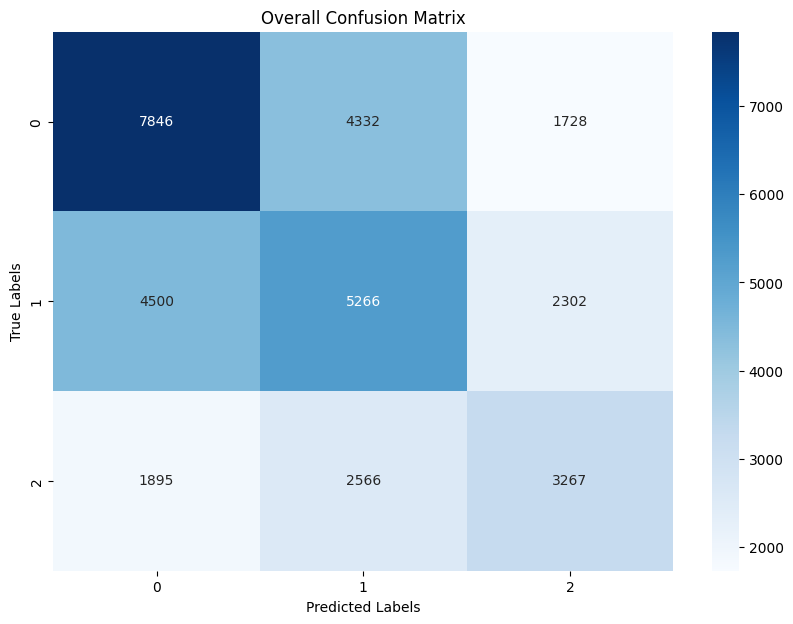

In [28]:
# IMPORTS
import pickle
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

# Load the user_models dictionary from the pickle file
with open('user_models.pkl', 'rb') as file:
    loaded_user_models = pickle.load(file)

# Initialize lists to collect all y_test and y_test_pred across all users
overall_y_test = []
overall_y_pred = []

# Iterate over each user and collect the test labels and predictions
for user, data in loaded_user_models.items():
    y_test = data.get('y_test', [])
    y_test_pred = data.get('y_test_pred', [])
    
    # Ensure both y_test and y_test_pred are not empty
    if y_test and y_test_pred:
        overall_y_test.extend(y_test)
        overall_y_pred.extend(y_test_pred)

# Check if there is data to compute metrics
if not overall_y_test or not overall_y_pred:
    print("No test data available to compute overall metrics.")
else:
    # Compute Overall Metrics
    accuracy = metrics.accuracy_score(overall_y_test, overall_y_pred)
    precision = metrics.precision_score(overall_y_test, overall_y_pred, average='macro', zero_division=0)
    recall = metrics.recall_score(overall_y_test, overall_y_pred, average='macro', zero_division=0)
    f1 = metrics.f1_score(overall_y_test, overall_y_pred, average='macro', zero_division=0)
    conf_matrix = metrics.confusion_matrix(overall_y_test, overall_y_pred)
    class_report = metrics.classification_report(overall_y_test, overall_y_pred)
    
    # Print Overall Metrics
    print("\n=== Overall Metrics Across All Users ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"Recall (Macro): {recall:.4f}")
    print(f"F1-Score (Macro): {f1:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)
    
    # Optional: Plot the Confusion Matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=loaded_user_models[next(iter(loaded_user_models))]['model'].classes_,
                yticklabels=loaded_user_models[next(iter(loaded_user_models))]['model'].classes_)
    plt.title('Overall Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


In [ ]:
# IMPORTS
import pickle
from sklearn import metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the user_models dictionary from the pickle file
with open('user_models.pkl', 'rb') as file:
    loaded_user_models = pickle.load(file)

# Initialize a list to store per-user metrics
user_metrics = []

# Iterate over each user and compute test metrics
for user, data in loaded_user_models.items():
    y_test = data.get('y_test', [])
    y_test_pred = data.get('y_test_pred', [])
    
    # Ensure both y_test and y_test_pred are not empty
    if y_test and y_test_pred:
        # Compute metrics
        accuracy = metrics.accuracy_score(y_test, y_test_pred)
        precision = metrics.precision_score(y_test, y_test_pred, average='macro', zero_division=0)
        recall = metrics.recall_score(y_test, y_test_pred, average='macro', zero_division=0)
        f1 = metrics.f1_score(y_test, y_test_pred, average='macro', zero_division=0)
        
        # Append to the list
        user_metrics.append({
            'user': user,
            'accuracy': accuracy,
            'precision_macro': precision,
            'recall_macro': recall,
            'f1_macro': f1
        })

# Create a DataFrame from the list
metrics_df = pd.DataFrame(user_metrics)

# Check if any metrics were computed
if metrics_df.empty:
    print("No metrics were computed. Please ensure that user_models.pkl contains valid data.")
else:
    # Display the first few rows of the per-user metrics
    print("=== Per-User Metrics ===")
    print(metrics_df.head())
    
    # Compute aggregate metrics
    aggregate_metrics = metrics_df[['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']].agg(['mean', 'median', 'std'])
    
    print("\n=== Aggregated Metrics Across All Users ===")
    print(aggregate_metrics)
    
    # Optional: Visualize the distribution of each metric
    metrics_to_plot = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
    
    for metric in metrics_to_plot:
        plt.figure(figsize=(8, 6))
        sns.histplot(metrics_df[metric], kde=True, bins=30, color='skyblue')
        plt.title(f'Distribution of {metric.capitalize()} Across Users')
        plt.xlabel(metric.capitalize())
        plt.ylabel('Frequency')
        plt.show()


# Training the Final Content Based Decision Tree on the Entire FULL Dataset

In [ ]:
# IMPORTS
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import numpy as np
import pickle

# Initialize a dictionary to store user models and their prediction data
user_models = {}

# Initialize an array to store user IDs where model training failed
failed_users = []

# Iterate through each user in the ratings dataframe
for user in ratings_df_slim['user'].unique():
    try:
        # Get all the ratings for the current user
        user_ratings = ratings_df_slim[ratings_df_slim['user'] == user]
        
        # Get the subset of the Wines Dataset that the user has rated
        user_wines = wines_df_slim[wines_df_slim['item'].isin(user_ratings['item'])]
    
        # Merge user_ratings with user_wines on the 'item' column
        merged_data = pd.merge(user_ratings, user_wines, on='item', how='inner')
        
        # Specify which features we are NOT gonna use in X
        features_to_drop_for_X = ['RatingID', 'user', 'item', 'rating_label']
        
        # Ensure that the columns to drop exist in merged_data to prevent KeyError
        existing_features_to_drop = [col for col in features_to_drop_for_X if col in merged_data.columns]
        
        # Get X and y
        X = merged_data.drop(columns=existing_features_to_drop)
        y = merged_data['rating_label']
        
        # Handle missing values if any
        X = X.fillna(0)  # Example: Fill NaNs with 0. Adjust as needed
        y = y.fillna(y.mode()[0])  # Example: Fill NaNs in target with mode. Adjust as needed
        
        # Convert all features to numeric, coercing errors and filling NaNs with 0
        # Uncomment the following line if your features are not already numeric
        # X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
        
        # Identify the wines not rated by the user
        all_wine_ids = set(wines_df_slim['item'].unique())
        rated_wine_ids = set(user_wines['item'].unique())
        unrated_wine_ids = list(all_wine_ids - rated_wine_ids)
        
        # Get the subset of wines not rated by the user
        unrated_wines = wines_df_slim[wines_df_slim['item'].isin(unrated_wine_ids)]
        
        # Prepare features for prediction
        # Ensure that the features in X and unrated_wines match
        # If necessary, perform the same preprocessing steps on unrated_wines
        X_unrated = unrated_wines.drop(columns=features_to_drop_for_X, errors='ignore')
        X_unrated = X_unrated.fillna(0)  # Handle missing values as done for X
        
        # Initialize the Decision Tree Regressor
        # Note: Changed to DecisionTreeRegressor since we're predicting ratings (continuous values)
        clf = DecisionTreeRegressor(max_depth=3, random_state=42)
        
        # Fit the model on the entire user data
        clf.fit(X, y)
        
        # Predict ratings for unrated wines
        y_unrated_pred = clf.predict(X_unrated)
        
        # Create a dataframe with wine IDs and predicted ratings
        predicted_wines_df = pd.DataFrame({
            'item': unrated_wines['item'].values,
            'predicted_rating': y_unrated_pred
        })
        
        # Sort the dataframe by predicted ratings in descending order
        predicted_wines_df_sorted = predicted_wines_df.sort_values(by='predicted_rating', ascending=False).reset_index(drop=True)
        
        # Store the model, rated wines, and predicted wines in the user_models dictionary
        user_models[user] = {
            'model': clf,
            'rated_wines': list(rated_wine_ids),
            'predicted_wines': predicted_wines_df_sorted
        }
        
    except Exception as e:
        # Append the user ID to failed_users and continue
        failed_users.append(user)
        print(f"Failed to train model for user {user}: {e}")

# After processing all users, you can inspect the failed_users array
print(f"Number of users with failed model training: {len(failed_users)}")

# Optionally, to view the list of these user IDs:
# print("Users with failed model training:", failed_users)

# Save the user_models dictionary to a pickle file for future use
with open('user_models_slim_trained.pkl', 'wb') as file:
    pickle.dump(user_models, file)

print("User models saved successfully as 'user_models_slim_trained.pkl'.")


In [21]:
import pickle
import pandas as pd
import random  # Importing random module to select a random user

# Load the user_models dictionary from the pickle file
with open('user_models_slim_trained.pkl', 'rb') as file:
    loaded_user_models = pickle.load(file)

# Check if loaded_user_models is not empty
if not loaded_user_models:
    print("The user_models dictionary is empty. Please ensure that models have been trained and saved correctly.")
else:
    # Select a random user from the dictionary keys
    sample_user = random.choice(list(loaded_user_models.keys()))
    
    # Retrieve the user data
    user_data = loaded_user_models[sample_user]
    model = user_data['model']
    rated_wines = user_data['rated_wines']
    predicted_wines = user_data['predicted_wines']
    
    # Define the number of top recommendations you want
    top_n = 10
    
    # Check if there are enough predicted wines to recommend
    if predicted_wines.empty:
        print(f"No unrated wines available to recommend for User {sample_user}.")
    else:
        # Display top N recommended wines
        top_recommendations = predicted_wines.head(top_n)
        
        print(f"\nTop {top_n} Recommended Wines for User {sample_user}:")
        print(top_recommendations)



Top 10 Recommended Wines for User 1003250:
     item  predicted_rating
0  138479               2.0
1  144468               2.0
2  144337               2.0
3  111466               2.0
4  174121               2.0
5  174184               2.0
6  111457               2.0
7  144083               2.0
8  174330               2.0
9  114932               2.0
